# MS-263 Final Project
## Exploring the Relation between Temperature and Current Velocity from a Mooring in Stillwater Cove
#### Logan Grady

## Introduction
Monterey Bay, California is well known for many of its unique biological, physical, and geographic features. The main inlet of the bay is home to large submarine canyon that stretches for miles offshore and reaches thousands of meters of depth. Consistent northeasterly winds cause upwelling in Ano Nuevo to the north, Big Sur to the south, lifting up large concentrations of deep water nutrients that stimulate some of the most productive ecosystems on the planet. Stemming off of the much larger Monterey Canyon, and reaching around the southern side of the Monterey peninsula is the Carmel Canyon, which reaches far inshore of Carmel Bay. While the main inlet of Monterey bay has had much research conducted on the physical processes that govern the patterns of temperature and water movement, less can be said about this smaller inlet south of the peninsula. 

A recent study by Anna Lowe (2020) looked into the circulation patterns of Carmel Bay in order to study the connectivity of larva dispersion in the biologically productive region. This study was conducted using the Regional Ocean Modeling System to simulate circulation in Camrel Bay during the 2014/15 upwelling seasons. The study's extensive analysis found that upwelling from the nearby canyon was weaker than upwelling in locations such as Ano Nuevo and Point Sur, but was able to provide cold, nutrient rich water into the smaller bay. An earleir study conducted by Dustin Carroll in 2009 found similar patterns of deepwater transport from the canyon. Carroll's study concluded that internal waves coming from the Carmel Canyon were able to bring an extra source of nutrients into nearby ecosystems, however locations that were farther on the shelf were not subsidized by the internal waves. 

This project aims to build upon the work of previous studies done in Carmel Bay by looking at an extensive time series of temperature and water velocity data collected by a single mooring placed by PISCO in the 2000, and was pulled out in 2011. This mooring is located in the northern region of the bay in Stillwater Cove. Using the data collected from this mooring, I would like to explore the hydrodynamics of Stillwater Cove and look into how currents and temperature may be related at this location. 

Some potential questions I attempt to answer:
   1. How alongshore and across shore velocity vary with time?
   2. Is there any significant relationship between alongshore/acrosshore velocity and temperature?
   3. What physical features of the water column can be analyzed with the data from this mooring?
   4. How do the physical properties of this location vary seasonally?

# Import all packages

In [1]:
# Basic packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os

# Plotting
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sn

# For making maps
import cartopy.crs as ccrs
from maptools import make_map

# Custom functions made for data importation and analysis
import data_prep_functions as dat
import fp_plotting as fpp
import data_analysis as da

# Packages for data analysis
from scipy import stats
from scipy import linalg
from scipy.signal import periodogram
from scipy.signal import welch
from scipy.stats import chi2

# Study Site
The location of the mooring is in Stillwater Cove at a depth of 22 meters. Using the bathymetry data gives a little context into the seafloor environment for this site. The Carmel Canyon runs inshore farther south of Stillwater Cove, however, the effects of upwelling from the canyon can still be detected in this location.

C:\Users\Chili\anaconda\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Chili\anaconda\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


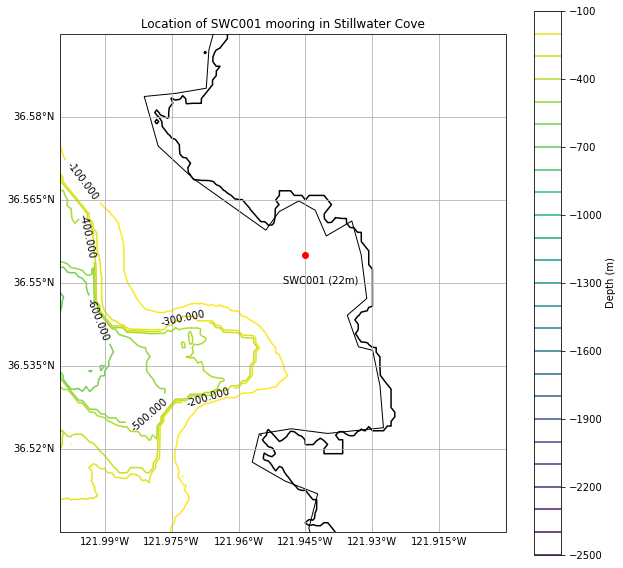

In [2]:
# Load the bathymetry data and convert it into an xarray dataset
bathy_nc = 'coastal_relief_model/crm_vol6_subset.nc'
ds = xr.open_dataset(bathy_nc)

# Create a subset of coordinates to display only Stillwater
dsub = ds.sel(x=slice(-122, -121.9), y=(slice(36.505, 36.595)))

# Plot the map projection with bathymetry contours and location of SWC001 mooring
plt.figure(figsize=(10,10))
ax = make_map(projection = ccrs.Mercator())
ax.set_extent([-122, -121.9, 36.505, 36.595])
cs = plt.contour(dsub['x'], dsub['y'], dsub['z'], np.arange(-2500, 0, 100), transform=ccrs.PlateCarree())
plt.colorbar(label='Depth (m)')
plt.clabel(cs, colors='k')
plt.contour(dsub['x'], dsub['y'], dsub['z'], [0], transform=ccrs.PlateCarree(), colors='k')
plt.plot(-121.945, 36.555, 'ro', transform=ccrs.PlateCarree())
ax.text(-121.95, 36.55, 'SWC001 (22m)', transform=ccrs.PlateCarree())
plt.title('Location of SWC001 mooring in Stillwater Cove')
ax.coastlines()

#plt.savefig('mooring_location.PNG')

# Methods
The plan for this project is to take a section of data from a clean and continuous year of data and conduct EOF analysis to find the dominant EOF modes for each velocity and temperature component. In order for EOF analysis to be possible, the vector data must be manipulated so that it is converted from geographic velocity data to alongshore and across shore velocity components. Once the data is properly adjusted, EOF analysis can be used to determine the amount of variance accounted for by each factor's dominant EOF modes. 

To find the EOF modes for each factor, eigenvalue and eigenvector must be created for each individual component being analyzed. For this project, the components I'm interested in are the alongshore and across shore velocity, as well as the temperature. Once the eigenvalue and eigenvector matrices are created for these three components, a factor loading matrix will be created for each. The columns of the factor loading matrix are the EOF modes. The dominant EOF modes will be plotted and qualitatively analysed to determine which modes are acceptable and which are insignificant.

Once the dominant modes have been selected for each factor, a time series of the dominant modes can be generated for each factor. These time series will be compared with the empirical data to describe the hydrologic structure of Stillwater Cove. The dominant modes will then be put into a correlation matrix with the empirical temperature data to compare which modes and factors contribute to variability in the temperature structure of Stillwater Cove. Conclusions can then be drawn on the viability of the dominant modes as proxies for the data, and how the physical factors of Stillwater Cove relate to each other.

# Import data

The SWC001 mooring comes with 4 thermistors on a line at 0, 5, 13, and 21 meters of depth. They sample temperature in 2 minute intervals. The goal of importing this data is to combine all of the seperate monthly datasets into one comprehensive dataframe which can be easily manipulated and analyzed. A Sentinnel Workhorse ADCP is located at the base of the thermistor chain in 21 meters of water. It takes averaged velocity samples in 2 minute intervals, sampling the northward, eastard, and upward velocity for every meter of water. The full data from SWC001 is 11 years long, and often messy and incomplete. The data from the year 2002 is relatively complete, so I will be using 2002 for this project.

In [3]:
# Importing the thermistor data using custom functions. Further description of code available in 'data_prep_functions.py'

# This array is for the therm_data_merge function so that the correct depths of data are imported
depth = [0,5,13,21]

# This function takes the raw data from the Data directory and converts it into a pandas dataframe
raw_therm_02 = dat.therm_data_merge('Thermistor', 2002, depth)

# Takes the pandas dataframe from before and converts it into an xarray dataset
therm_02 = dat.therm_pd_to_xr(raw_therm_02, depth)

In [4]:
# With an organised dataset, I can begin to filter and manipulate the data to be more analysis friendly
therm_ref = dat.xr_therm_analysis(therm_02, "1H", 1, 24)

# Temperature data is now averaged over 1 hour intervals and low-pass filtered to exclude all variability on timescales less than 24 hours
therm_ref

<xarray.Dataset>
Dimensions:               (depth: 4, time: 8737)
Coordinates:
  * time                  (time) datetime64[ns] 2002-01-01 ... 2002-12-31
  * depth                 (depth) int32 0 5 13 21
Data variables:
    temperature           (time, depth) float64 nan nan nan nan ... nan nan nan
    temperature_filtered  (time, depth) float64 nan nan nan nan ... nan nan nan

In [5]:
# Imports the adcp data and converts it into a more analysis friendly xr dataset

# Converts raw adcp excel files to pandas dataframe
raw_adcp_02 = dat.adcp_data_merge('ADCP', 2002)

# Converts dataframe to xarray dataset with northwards and eastwards velocities as products of time and depth
adcp_02 = dat.adcp_pd_to_xr(raw_adcp_02)

Once the basic dataset has been created, I run it through the custom function 'xr_adcp_analysis' to prep the data for principle component analysis:
1. Average the data over 1 hour intervals
2. Apply a low-pass filter to exclude all variability on timescales less than 24 hours
3. Average the north and eastward components over depth to get a single velocity vector for each directional component
4. Use the depth-averaged vectors to find the angle of rotation using the princax function
5. Use the angle of rotation to plot vectors along principle axes. Northward becomes alongshore, eastward becomes across shore
6. Find the depth average of the new principal components for future analysis

In [6]:
adcp_ref = dat.xr_adcp_analysis(adcp_02, "1H", 1, 24)
adcp_ref

<xarray.Dataset>
Dimensions:             (depth: 21, time: 6073)
Coordinates:
  * time                (time) datetime64[ns] 2002-02-21T21:00:00 ... 2002-11...
  * depth               (depth) float64 -0.1 0.9 1.9 2.9 ... 16.9 17.9 18.9 20.9
Data variables:
    northward           (time, depth) float64 nan nan nan ... -0.001368 nan nan
    eastward            (time, depth) float64 nan nan nan ... -0.02779 nan nan
    northward_filtered  (time, depth) float64 nan nan nan nan ... nan nan nan
    eastward_filtered   (time, depth) float64 nan nan nan nan ... nan nan nan
    north_da            (time) float64 nan nan nan nan nan ... nan nan nan nan
    east_da             (time) float64 nan nan nan nan nan ... nan nan nan nan
    alongshore          (time, depth) float64 nan nan nan nan ... nan nan nan
    crossshore          (time, depth) float64 nan nan nan nan ... nan nan nan
    alongshore_da       (time) float64 nan nan nan nan nan ... nan nan nan nan
    crossshore_da       (time) float64 nan nan nan nan nan ... nan nan nan nan

# Visualising the principal axes
In order to calculate the empirical orthogonal function modes of the velocity components, the data must be converted into its principal components. This is done by rotating the coordinate system so that northward vs. eastward becomes alongshore (parallel to shore) vs. across shore (perpendicular to shore) velocity. The along/across shore velocities are more useful in the case of this project since they do not covary with each other, allowing the vectors to be analyzed individually without biasing each other. 

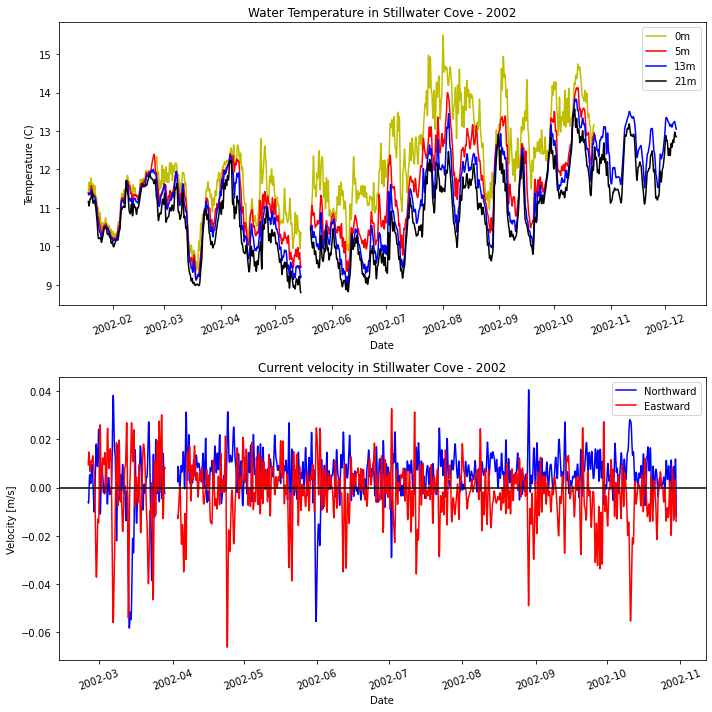

In [7]:
# Plots all 4 depths of thermistor data on one long 
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=0), '-y')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=1), '-r')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=2), '-b')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=3), '-k')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title('Water Temperature in Stillwater Cove - 2002')
plt.xticks(rotation=20)
plt.legend(['0m','5m','13m','21m'])

# Plots the depth averaged and unrotated northward and eastward velocities
plt.subplot(212)
plt.plot(adcp_ref.time, adcp_ref.north_da, '-b')
plt.plot(adcp_ref.time, adcp_ref.east_da, '-r')
plt.axhline(y=0,c='k')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.title('Current velocity in Stillwater Cove - 2002')
plt.xticks(rotation=20)
plt.legend(['Northward', 'Eastward'])

plt.tight_layout()
#plt.savefig('raw_data_plots.PNG')

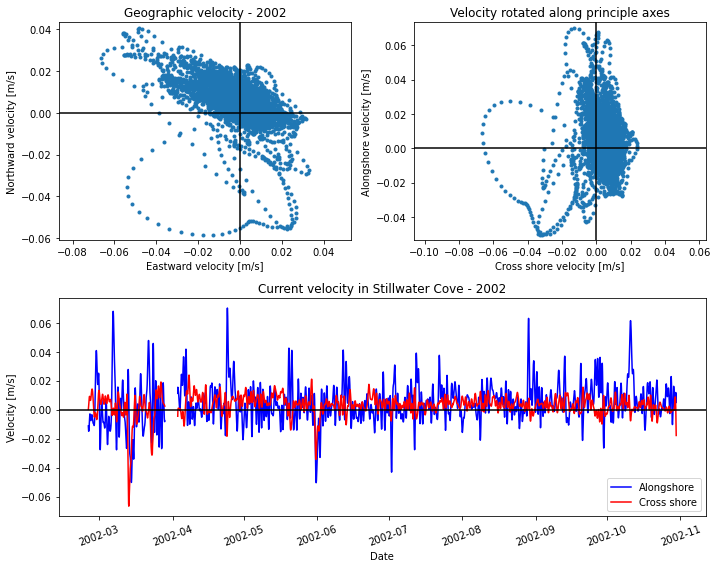

In [8]:
# Plots the depth average, unrotated vectors
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(adcp_ref.east_da, adcp_ref.north_da,'.')
plt.axis('equal')
plt.axvline(x=0,c='k')
plt.axhline(y=0,c='k')
plt.xlabel('Eastward velocity [m/s]')
plt.ylabel('Northward velocity [m/s]')
plt.title('Geographic velocity - 2002')

# plots the depth averaged vectors with the coordinate system rotated along principal axes
plt.subplot(222)
plt.plot(adcp_ref.crossshore_da, adcp_ref.alongshore_da,'.') # No longer plotting northward vs. eastward velocity, but alongshore vs. across shore
plt.axis('equal')
plt.axvline(x=0,c='k')
plt.axhline(y=0,c='k')
plt.xlabel('Cross shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
plt.title('Velocity rotated along principle axes')

# Plot the principal vectors as a time series to expose temporal trends
plt.subplot(212)
plt.plot(adcp_ref.time, adcp_ref.alongshore_da, '-b')
plt.plot(adcp_ref.time, adcp_ref.crossshore_da, '-r')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.title('Current velocity in Stillwater Cove - 2002')
plt.axhline(y=0,c='k')
plt.xticks(rotation=20)
plt.legend(['Alongshore', 'Cross shore'])

plt.tight_layout()
plt.show
#plt.savefig('princax_vectors.PNG')

As shown by the above plots, the vectors are now plotted on the principal axes coordinate system. We can envision this rotated blob of points as the variance of currents along the coast. If we envision the actual coastline to the right of the points, we can see that most variability in the current velocity is occuring in the alongshore direction, while a much smaller amount of the variability is occuring in the across shore. In the time series, plotting alongshore vs. across shore has also made peaks and troughs more easily identifiable. While the geographic velocity time series had combinations of current directions that were difficult to pick out, the principle component time series easily displays when transport is offshore/onshore, or going up/down the coastline.

# Creating the summer time series
If you take a look at the temperature time series plots from above, the general seasonal trends in temperature can be observed. The temperatures are well-mixed during the first two months of the year, and the water begins to stratify as spring and summer approach. During the summer months of June through August, temperature seems to have the most prominent variability. There is also a sizeable gap in the data during the month of May, making future analysis more difficult. For this project, the summer data for 2002 seemed like the best option for capturing the day to day variability of this system, and the stratification allows for each layer of water to be more easily analyzed. To account for the gap in May data, summer is defined as June 1st to August 31st

In [9]:
# Creates a new dataarray with the aforementioned summer dates
summer_alongshore = adcp_ref.alongshore.loc["2002-06-01 00:00":"2002-08-31 23:30"]

# Since NA values have to be removed for principal component analysis, the data has to be modified slightly
# The depths of 0-3m are within a range of tidal sea surface height varaibility, as well as backscattering from the adcp, so there are many inconsistencies and NA values
# depths of 19-21m suffer from similar inconsistencies, so they are dropped as well
summer_alongshore = summer_alongshore.isel(depth=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
# The finished data_array includes a depth range of 4-18 meters, which is still most of the water column

# All dates with NA values are dropped
summer_alongshore = summer_alongshore.dropna('time')
summer_alongshore

<xarray.DataArray 'alongshore' (time: 2208, depth: 15)>
array([[-5.25643803e-03, -1.04153117e-02, -1.70378166e-02, ...,
        -4.10051549e-02, -3.44037079e-02, -2.56834776e-02],
       [-1.31559932e-03, -7.32326980e-03, -1.47390251e-02, ...,
        -3.87101280e-02, -3.27194684e-02, -2.44529791e-02],
       [ 2.49383778e-03, -4.45155024e-03, -1.26520812e-02, ...,
        -3.60206314e-02, -3.06340647e-02, -2.28725100e-02],
       ...,
       [ 3.24685925e-03,  8.26987129e-05, -1.95279742e-03, ...,
        -2.31160436e-03, -1.61678490e-03, -5.77066329e-04],
       [ 2.91405682e-03, -4.80625414e-04, -2.57899872e-03, ...,
        -2.34280033e-03, -1.41780500e-03, -3.13457119e-04],
       [ 3.31009595e-03, -3.13548872e-04, -2.47342970e-03, ...,
        -1.90753411e-03, -7.99574249e-04,  2.96204150e-04]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-31T23:00:00
  * depth    (depth) float64 3.9 4.9 5.9 6.9 7.9 ... 13.9 14.9 15.9 16.9 17.9

In [10]:
# Cross shore velocity is given the same treatment as alongshore
summer_crossshore = adcp_ref.crossshore.loc["2002-06-01 00:00":"2002-08-31 23:30"]
summer_crossshore = summer_crossshore.isel(depth=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
summer_crossshore = summer_crossshore.dropna('time')
summer_crossshore

<xarray.DataArray 'crossshore' (time: 2208, depth: 15)>
array([[-0.00395083, -0.00665415, -0.01079719, ..., -0.0135298 ,
        -0.00926833, -0.00847112],
       [-0.00424344, -0.00658672, -0.01063978, ..., -0.0115069 ,
        -0.00775794, -0.00748104],
       [-0.00486237, -0.00687297, -0.01081526, ..., -0.00960084,
        -0.00630821, -0.00648195],
       ...,
       [-0.00707348, -0.00612444, -0.00226265, ...,  0.00537605,
         0.00482745,  0.00172875],
       [-0.00685414, -0.00561683, -0.00143312, ...,  0.00601524,
         0.00543481,  0.00183056],
       [-0.00638781, -0.00491767, -0.00052836, ...,  0.00660293,
         0.00597888,  0.00183272]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-31T23:00:00
  * depth    (depth) float64 3.9 4.9 5.9 6.9 7.9 ... 13.9 14.9 15.9 16.9 17.9

In [11]:
# Temperature data was more consistent during this time period, so no depths are removed
summer_therm = therm_ref.temperature_filtered.loc["2002-06-01 00:00":"2002-08-31 23:30"]
summer_therm = summer_therm.dropna('time')
summer_therm

<xarray.DataArray 'temperature_filtered' (time: 2208, depth: 4)>
array([[10.8565943 , 10.76172474, 10.61507428, 10.05276208],
       [10.86387573, 10.76404167, 10.61282859, 10.07600351],
       [10.86889981, 10.76492252, 10.60895839, 10.09790947],
       ...,
       [13.16079066, 12.98763775, 12.64344514, 12.41799617],
       [13.17492142, 12.99023341, 12.62769804, 12.33111542],
       [13.17966528, 12.99325336, 12.61390703, 12.24749174]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-31T23:00:00
  * depth    (depth) int32 0 5 13 21

# EOF Mode Analysis
Now that all of the factors I'm interested in have been prepped and are in the correct format, they can be converted into matrices and multiplied together to form eigenvalue and eigenvector matrices. The eigenvalues are the variance accounted for by each principal component, and they determine how each column in the eigenvector matrix is scaled. The eigenvector matrix provides the orientation of the data along the principal component axis in a standardized form. Each column of the eigen vector matrix is a principal component, or an empirical orthogonal function mode (EOF mode). Each EOF mode is a generalized pattern of the dataset that accounts for a certain amount of variance. These EOF modes are useful in modelling, because they can provide a simplified vector that represents an entire system, assuming that the mode accounts for a significant magnitude of variance.

Once the eigenvalue and eigenvector matrices have been generated from a standardized dataset, the EOF modes can be plotted and analysed with respect to the empirical system. They can also be compared with other factors to determine how the two vary with each other. For this project, the alongshore, across shore, and temperature EOF modes will be calculated and compared with the empirical temperature data, to see how well each mode accounts for variations in summer temperature at each depth.

In [12]:
# the 'PCA' function takes our summer dataset, standardizes it from -1 to 1, then extracts the eigenvalues, eigenvectors, and factor loading matrix for EOF analysis

# For alongshore 
as_dat, as_val, as_val_frac, as_vec, as_fac_load = da.PCA(summer_alongshore)

# Across shore
cs_dat, cs_val, cs_val_frac, cs_vec, cs_fac_load = da.PCA(summer_crossshore)

# Temperature
t_dat, t_val, t_val_frac, t_vec, t_fac_load = da.PCA(summer_therm)

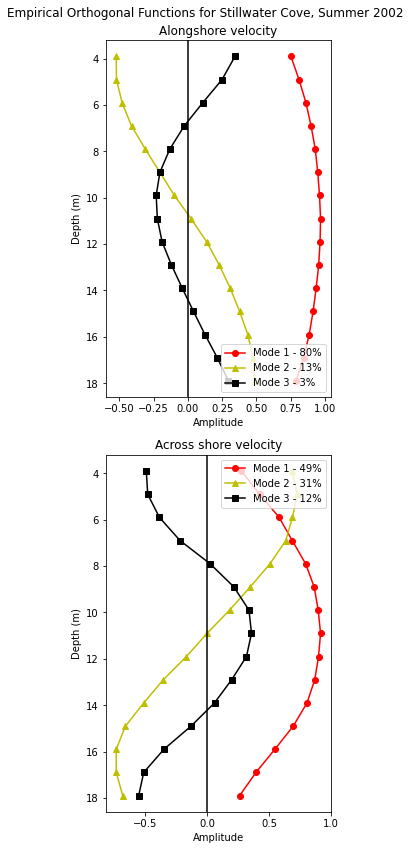

In [13]:
# Plotting the EOF modes for each component of velocity

plt.figure(figsize=(4,12))
symbols = ['o-r', '^-y', 's-k']

# Alongshore
plt.subplot(211)
variables = ['Mode 1 - ' + str(int(as_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(as_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(as_val_frac[2])) + '%'] # 'val_frac' is the eigenvalues converted in percentages
for i,txt in enumerate(variables):
    plt.plot((as_fac_load[:,i])*(-1), summer_alongshore.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='lower right')
plt.title('Alongshore velocity')

# Across shore
plt.subplot(212)
variables = ['Mode 1 - ' + str(int(cs_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(cs_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(cs_val_frac[2])) + '%']
for i,txt in enumerate(variables):
    plt.plot(cs_fac_load[:,i], summer_crossshore.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='upper right')
plt.title('Across shore velocity')
plt.suptitle('Empirical Orthogonal Functions for Stillwater Cove, Summer 2002')

plt.tight_layout()
#plt.savefig('EOF_Analysis _velocity.PNG')

### Alongshore
Mode 1 accounts for 80% of the variance in the system. The next two modes account for 16%, meaning that the next 15 modes account for 4%. This implies that all modes except for the first one are almost neglible, and could definitely not be used to explain the variance in the alongshore system. EOF mode 1 shows a slightly bowed line, where the surface has high positive amplitudes which increase until the middepth, where it begins to decrease back to surface depth amplitudes. Mode 1 shows unidirectional flow with uniform variability throughout the water column, deviating slightly at the surface and bottom depths. This is likely due to external forces such as bottom shearing at the lower depths, and wind/wave driven variability at the surface. 

### Across shore
The EOF modes for across shore velocity are much more equally distributed in their variance accountability than the alongshore modes. Cross shore mode 1 is similar to its alongshore counterpart in that flow is unidirectional, however the surface and bottom depth variability shows greater amplitude change. This means that other external forcing factors at the surface and bottom depths influence the across shore velocity much more than the alongshore. This is shown by the eigenvalues, where mode 1 accounts for only 48% of the total variance in the system, and mode 2 accounts for 31% of the variance. Together, these two EOF modes account for less variance than mode 1 in the alongshore direction. To me, this means that both mode 1 and 2 must be used when describing variability in the across shore direction

Across shore mode 2 describes a situation where flow at the surface and flow at the bottom are almost completely opposite of each other. The mid depth is an inflection point where variability is cancelled out by the surface and bottom depths. This process potentially describes an internal wave between two layers of water, or an upwelling/downwelling process, where surface water is moving offshore and bottom flow is moving onshore.

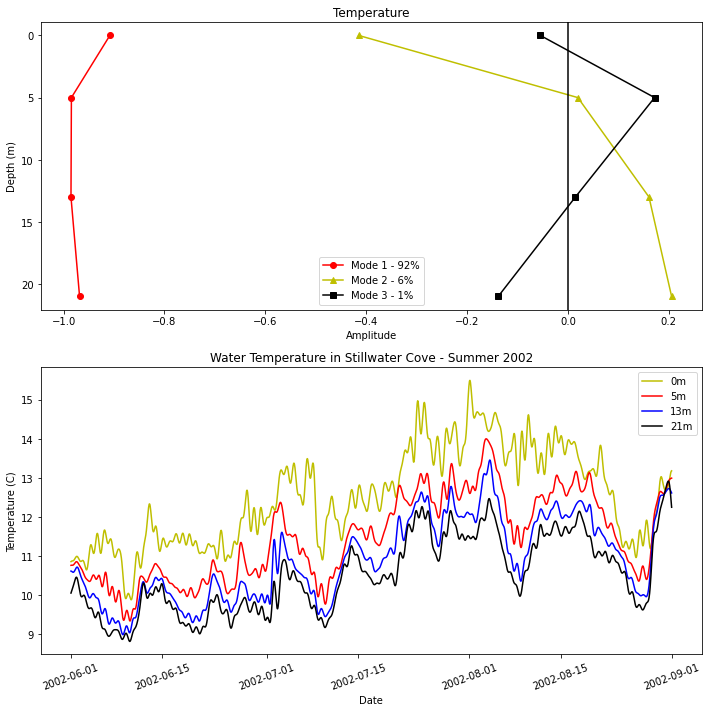

In [14]:
# Plot temperature EOF modes
plt.figure(figsize = (10,10))

plt.subplot(211)
variables = ['Mode 1 - ' + str(int(t_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(t_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(t_val_frac[2])) + '%']
for i,txt in enumerate(variables):
    plt.plot(t_fac_load[:,i], summer_therm.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='lower center')
plt.title('Temperature')

# Plot the empirical temperature data for reference
plt.subplot(212)
plt.plot(summer_therm.time, summer_therm.isel(depth=0), '-y')
plt.plot(summer_therm.time, summer_therm.isel(depth=1), '-r')
plt.plot(summer_therm.time, summer_therm.isel(depth=2), '-b')
plt.plot(summer_therm.time, summer_therm.isel(depth=3), '-k')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title('Water Temperature in Stillwater Cove - Summer 2002')
plt.xticks(rotation=20)
plt.legend(['0m','5m','13m','21m'])

plt.tight_layout()
#plt.savefig('EOF_Analysis_temp.PNG')

### Temperature
EOF mode 1 for temperature explains 92% of the total variance in the system, while high modes decrease in eigenvalue exponentially. This means that higher modes are insignificant for explaining the general patterns in the system, and do not need to be considered when modelling the temperature. Mode 1 shows a system where temperature variability is relativily uniform throughout the water column. The amplitude is lowest at the surface, where temperature changes more sporadically, but depths 5 meters and lower stay consistent with each other. This is reflected in the empirical temperature time series, where we see that all depths of temperature tend to increase and decrease in unison. The surface temperature doesn't follow the other depths as consistently, with smaller variations more often, which explains the slight decrease in amplitude at the surface.

# EOF Time Series
Using the calculated EOF modes for all of the factors, a time series for each factors can be created. These time series serve as a general index for how the empirical data follows the EOF mode. 

In [15]:
# Multiply the data matrix with the eigenvector matrix to get time series of EOF's

# Alongshore velocity
as_EOF_ts = (np.matmul(as_dat, as_vec))*-1 # Multiplied by -1 since the index is almost perfectly flipped with the empirical data

# Cross shore velocity
cs_EOF_ts = np.matmul(cs_dat, cs_vec)

# Temperature
t_EOF_ts = np.matmul(t_dat, t_vec)*-1

<ipython-input-16-d8177593b4c7>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(summer_alongshore.time, summer_alongshore.depth, summer_alongshore.T,norm=norm)
<ipython-input-16-d8177593b4c7>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(summer_crossshore.time, summer_crossshore.depth, summer_crossshore.T,norm=norm)


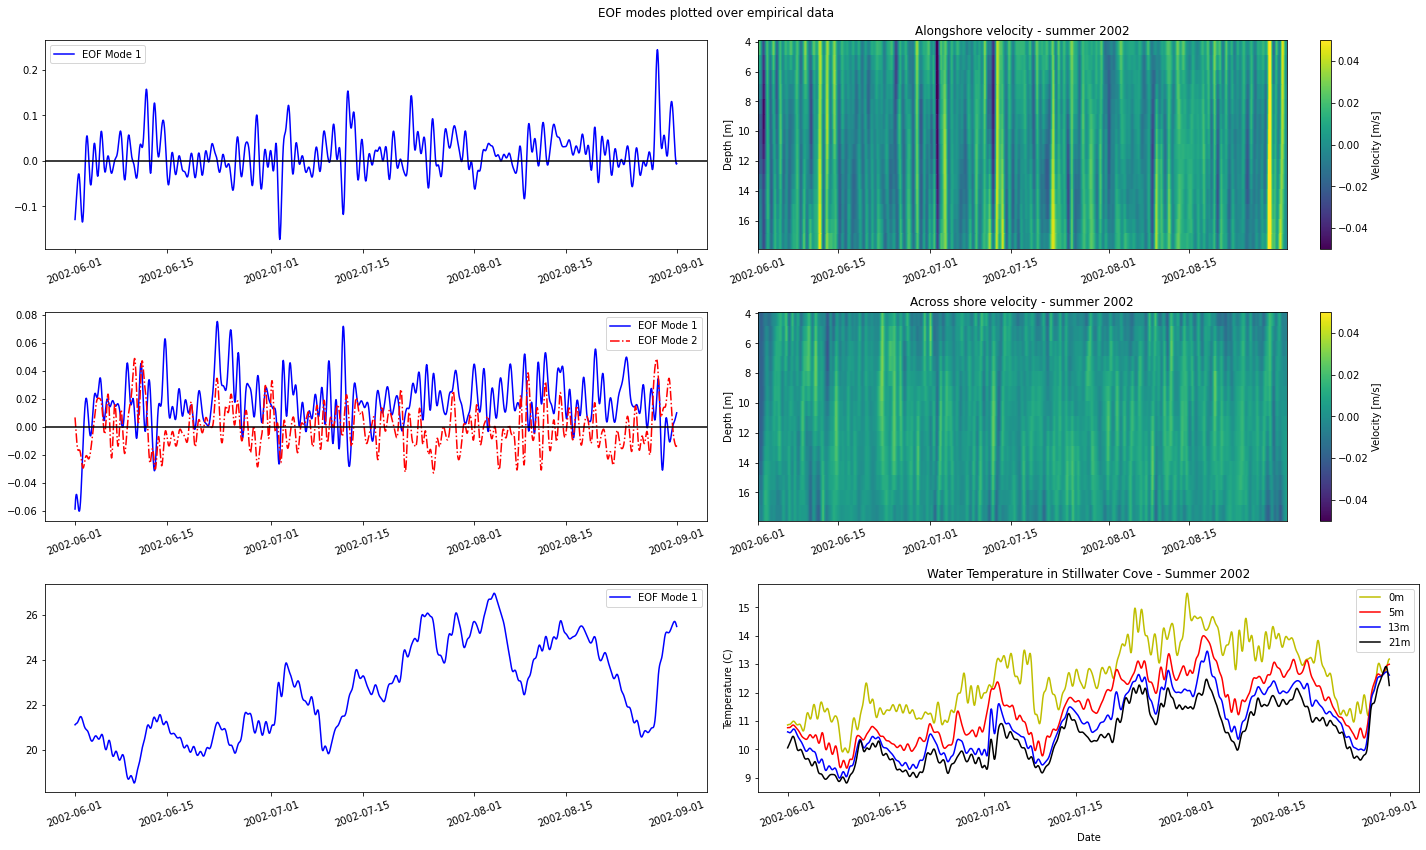

In [16]:
# Plot all EOF time series with their empirical counterparts
plt.figure(figsize = (20,12))
minvel = -.05 # Limits for the colorbars used on the adcp colorplots
maxvel = .05
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

# Alongshore EOF
plt.subplot(321)
plt.plot(summer_alongshore.time, as_EOF_ts[:,0], '-b')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.legend(['EOF Mode 1'])

# Alongshore color plot for empirical adcp data
plt.subplot(322)
plt.title('Alongshore velocity - summer 2002')
plt.pcolormesh(summer_alongshore.time, summer_alongshore.depth, summer_alongshore.T,norm=norm)
plt.colorbar(label='Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xticks(rotation='20')
plt.gca().invert_yaxis()

# Across shore EOF
plt.subplot(323)
plt.plot(summer_crossshore.time, cs_EOF_ts[:,0], '-b')
plt.plot(summer_crossshore.time, cs_EOF_ts[:,1], '-.r') 
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.legend(['EOF Mode 1', 'EOF Mode 2'])

# Across shore colorplot
plt.subplot(324)
plt.title('Across shore velocity - summer 2002')
plt.pcolormesh(summer_crossshore.time, summer_crossshore.depth, summer_crossshore.T,norm=norm)
plt.colorbar(label='Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xticks(rotation='20')
plt.gca().invert_yaxis()

# Temperature EOF
plt.subplot(325)
plt.plot(summer_therm.time, t_EOF_ts[:,0], '-b')
plt.xticks(rotation=20)
plt.legend(['EOF Mode 1'])

# Plot of empirical temperature
plt.subplot(326)
plt.plot(summer_therm.time, summer_therm.isel(depth=0), '-y')
plt.plot(summer_therm.time, summer_therm.isel(depth=1), '-r')
plt.plot(summer_therm.time, summer_therm.isel(depth=2), '-b')
plt.plot(summer_therm.time, summer_therm.isel(depth=3), '-k')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title('Water Temperature in Stillwater Cove - Summer 2002')
plt.xticks(rotation=20)
plt.legend(['0m','5m','13m','21m'])

plt.suptitle('EOF modes plotted over empirical data')
plt.tight_layout()
#plt.savefig('EOF_emp_comp.PNG')

### Alongshore
The alongshore EOF mode 1 appears to be a good predictor of the alongshore depth structure. When the amplitude of the Mode 1 increases, the empirical data on the right shows a high degree of conformity throughout the water column. Positive amplitudes yield a positive alongshore velocity, and negative amplitudes yield a negative velocity. One such example is the final two peaks in the EOF time series. The amplitude at these peaks reaches high positive values, which coincides with a strongly positive and uniform velocity in the empirical data. Likewise, the trough in amplitude around the beginning of July coincides with a strong and uniform negative velocity in the empirical data.

### Across Shore
For EOF mode 1, peaks indicate regions in the empirical data where the mid depth has the highest velocity magnitude with a damped velocity at the surface and bottom. This is best showcased around the middle of July, where there is a large peak in EOF mode 1 amplitude right before July 15th. This mode shows a high magnitude of positive velocity with much slower velocities at thee surface and bottom depths. EOF mode 2 accounts for bi-directional flow, and is best showcased at the end of the time series, where there are two peaks in mode 2 amplitude. These peaks correspond to a strong negative velocity at deeper depths, and a positive velocity at shallower depths, which is reflected in the empirical data at the end of the time series.

### Temperature
For temperature, the correlation between EOF mode 1 and the empirical data appears very clearly. The amplitude of mode 1 follows the general trend of the empirical temperature data very closely, and mimics the pattern of general increase in temperature with time during the summer. I would feel confident using this EOF mode in future analysis and models looking at temperature with other factors.

# Correlation Matrix
The goal of the correlation matrix is to take all of the EOF modes being observed and compare them with other factors. For this matrix, I want to compare all of the relevant EOF modes with the empirical temperature to see which modes can account for the variability in temperature structure for Stillwater Cove.

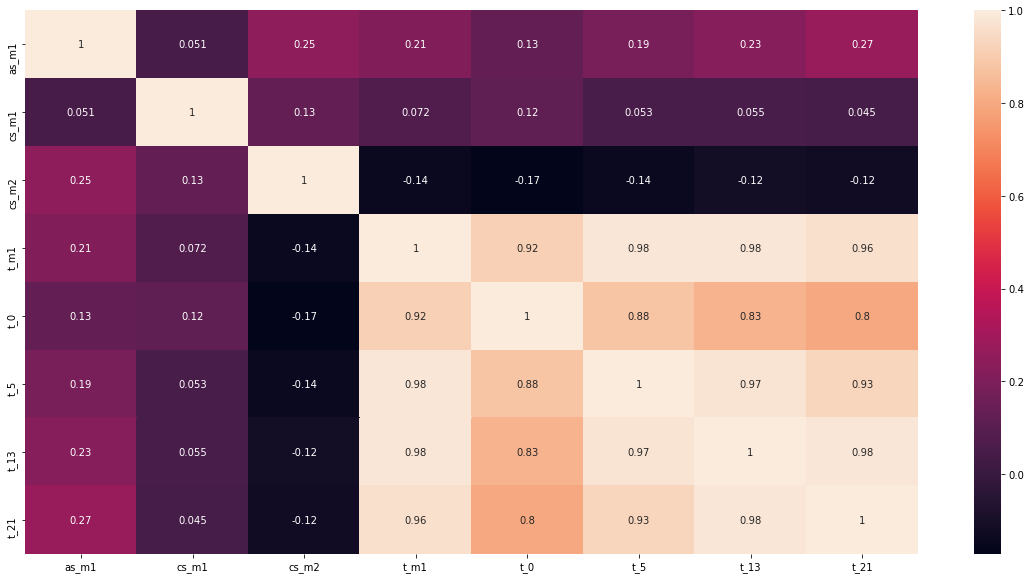

In [17]:
# Create a dataframe with all relevant EOF modes and empirical temperature data.
data_all = {'as_m1': as_EOF_ts[:,0],
        'cs_m1': cs_EOF_ts[:,0],
        'cs_m2': cs_EOF_ts[:,1],
        't_m1': t_EOF_ts[:,0],
        't_0': summer_therm.isel(depth=0),
        't_5': summer_therm.isel(depth=1),
        't_13': summer_therm.isel(depth=2),
        't_21': summer_therm.isel(depth=3)}

df_all = pd.DataFrame(data_all)

corrMatrix_all= df_all.corr()

plt.figure(figsize=(20,10))
sn.heatmap(corrMatrix_all, annot=True)
#plt.savefig('corr_mat.PNG')

### Trends in the correlation matrix
1. The alongshore EOF mode 1 has a moderate, positive correlation with temperature which increases with depth.
2. Across shore mode 2 has a weak, negative correlation with temperature, which increases slightly with depth.
3. Temperature mode 1 is highly correlated with all depths of temperature.

# Conclusions
The PISCO dataset is extremely robust and provides an extensive time series with useful temperature and velocity data. The work done in this project only scratches the surface of EOF analysis for these physical factors, and the time series covered is only during the summer of one of the years. Despite this, the data collected here has given me some key insights into the flow and temperature variability at stillwater with depth. 

The alongshore EOF mode 1 accounts for 80% of the variability in the time series, and comparing it to the empirical data proves that it can be used to predict the alongshore velocity structure at Stillwater during the summer. According to the correlation matrix, this mode is also moderately correlated with temperature. A positive amplitude in mode 1 corresponds to a positive, uniform alongshore velocity in Stillwater, implying that an upcoast alongshore velocity brings on warmer temperatures. The temperature tends to be warmer at the bottom during these positive mode 1 events.

The across shore modes are less absolute than their alongshore counterparts. Mode 1 only explains 48%, while mode 2 explains 31%. Together, they do not explain the percent of variance that alongshore mode 1 does, however they are still capable predictors of the across shore structure. Positive amplitudes for mode one correspond to high postive velocities in the mid depths, with decaying velocities farther at the surface and at the bottom. This decay of velocity at the upper and lower boundaries can likely be explained by other modes which account for bottom shear and surface wave interference. A positive amplitude for across shore mode 2 relates to a downwelling pattern in velocity, where bottom velocity is moderately negative (offshore), and surface velocity is moderately postive (onshore). This also implies that a negative amplitude for mode 2 corresponds to upwelling. Something that may require more analysis is the correlation between across shore mode 2 and empirical temperature. Temperature is negatively correlated with mode 2, so when mode 2 amplitude increases, representing downwelling, I would expect temperature to increase as warm surface water is brought down, however the opposite occurs. More analysis is needed to explain this potential phenomenon.

Temperature mode 1 is highly correlated with empirical temperature and accounts for 92% of the variance in the empirical temperature data. Looking at the EOF time series for mode 1 versus the empirical data, I can say that this mode is a great predictor of temperature, and can be used in other models for Stillwater Cove.

# Future Work
As mentioned previously, I have only scratched the surface of what can be done with this EOF analysis. Alongshore and temperature first modes, as well as the first two modes for across shore velocity, should be examined with other physical factors to try and account for more variance in other systems of Stillwater Cove. Wind and atmospheric temperature data should be looked into for this system, as it may account for some of the variance in these systems. Across shore variations still pose some mystery, and I'm curious if some of the variability is caused by upwelling/downwelling, or smaller internal waves. Spectral analysis is required to answer these questions, which I was unfortunately unable to get to during this project. 

The PISCO dataset is extensive, and deserves to be explored further. 2002 was not the only year with clean data, and the ability to average the samples over 1 hour intervals can allows other years of data to be used just as effectively. Looking at EOF modes through time may give insight into how Stillwater Cove is changing through time, or remaining stable.

# References

Carroll, Dustin, "Carmel Bay : oceanographic dynamics and nutrient transport in a small embayment of the central California coast" (2009). Capstone Projects and Master's Theses. 69.
    https://digitalcommons.csumb.edu/caps_thes/69

Lowe, A. B. (2020). Modeling of coastal processes and Lagrangian transport around the Monterey Peninsula. UC Santa Cruz. ProQuest ID: Lowe_ucsc_0036E_12120. Merritt ID: ark:/13030/m5tj41jf. 
    Retrieved from https://escholarship.org/uc/item/4tf8p3r9

Also a special thanks to Miya Pavlocke who contributed some base code which helped me understand how to utilize xarray to import the adcp data and manipulate it to be more easily analyzed.